In [1]:
import pandas as pd
import matplotlib
matplotlib.rcParams["font.family"] = "Arial"
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

Matplotlib created a temporary cache directory at /scratch/naotok/13419516/matplotlib-6j114b5y because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# PCA

## Load TPM matrix

In [ ]:
# Jul24
tpm_matrix_df = pd.read_csv("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/Shiba/results/expression/TPM.txt", sep = "\t")
tpm_matrix_df.head()

,gene_name,WT_F_1,WT_F_2,WT_F_3,KO_F_1,KO_M_3,KO_M_4
0,ENSMUSG00000000001,148.51,162.19,93.35,138.35,207.90,153.99
1,ENSMUSG00000000003,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSMUSG00000000028,12.14,12.34,14.81,10.39,13.46,7.98
3,ENSMUSG00000000031,0.00,0.00,1.60,0.13,0.00,0.09
4,ENSMUSG00000000037,0.50,1.47,0.31,0.87,1.32,0.93


In [3]:
# mouse neuronal development (ENCODE)
tpm_matrix_neuron_df = pd.read_csv("/rhome/naotok/bigdata/NeuronalMaturationSplicing/splicing/ENCODE_Mouse_Forebrain/Shiba/results/expression/TPM.txt", sep = "\t")
# group
group_df = pd.read_csv("/rhome/naotok/NeuronalMaturationSplicing/scripts/splicing/experiment_SRP055008.txt", sep = "\t", usecols = ["sample", "group"])
group_dict = {k: v for k, v in zip(group_df["sample"], group_df["group"])}
# tpm_matrix_neuron_df.columns = [group_dict[x] + "_" + x if x != "gene_name" else x for x in tpm_matrix_neuron_df.columns]
tpm_matrix_neuron_df

,gene_name,E10_1,E10_2,E11_1,E11_2,E12_1,E12_2,E13_1,E13_2,E14_1,E14_2,E15_1,E15_2,E16_1,E16_2,P0_1,P0_2
0,ENSMUSG00000000001,400.49,403.06,405.24,409.96,361.80,350.19,344.52,323.48,277.07,331.06,318.31,313.68,302.30,374.14,203.27,189.41
1,ENSMUSG00000000003,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSMUSG00000000028,93.58,96.48,87.78,82.49,59.77,57.02,54.69,50.93,34.08,33.55,25.54,28.54,23.00,24.77,5.14,5.23
3,ENSMUSG00000000031,106.12,126.04,101.61,93.43,56.20,70.33,28.95,28.38,30.35,35.03,26.93,31.31,25.47,37.60,14.53,14.27
4,ENSMUSG00000000037,3.80,3.70,4.45,5.69,4.68,4.16,3.72,3.08,3.32,3.51,3.63,2.96,3.29,3.57,1.90,1.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55482,ENSMUSG00000118655,2.60,2.25,1.45,3.01,3.45,1.72,3.77,1.27,0.59,0.80,2.44,2.66,3.92,2.17,0.00,0.00
55483,ENSMUSG00000118656,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55484,ENSMUSG00000118657,0.76,0.00,1.38,0.00,0.00,0.00,0.90,0.00,0.00,0.00,1.68,1.83,1.14,1.37,0.00,0.00
55485,ENSMUSG00000118658,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Merge

In [ ]:
tpm_matrix_merge_df = pd.merge(tpm_matrix_df, tpm_matrix_neuron_df, on = "gene_name")
tpm_matrix_merge_df = tpm_matrix_merge_df.set_index("gene_name")

In [5]:
def mtx2pca(df, genes) -> pd.DataFrame:
    '''
    Perform PCA on the input dataframe

    Args:
    - df (pd.DataFrame): input dataframe
    - genes (int): number of highly-variable genes to calculate PCs

    Returns:
    - feature_df (pd.DataFrame): dataframe containing principal components
    - contribution_df (pd.DataFrame): dataframe containing the contribution of each principal component
    '''
    df = df.dropna()
    # Keep rows of top n highly-variable genes
    if df.shape[0] > genes:
        df = df.loc[df.var(axis=1).sort_values(ascending=False).index[:genes]]
    # Z-score normalization across samples
    normalized_df = df.T.apply(stats.zscore, ddof = 1)
    # PCA
    pca = PCA()
    pca.fit(normalized_df)
    # Feature
    feature = pca.transform(normalized_df)
    feature_df = pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(feature))])
    feature_df.index = df.columns
    # Contribution
    contribution_df = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(feature))])
    return(feature_df, contribution_df)

In [6]:
feature_df, contribution_df = mtx2pca(tpm_matrix_merge_df, 3000)
PC1_contribution = (contribution_df[0][0]*100).round(2)
PC2_contribution = (contribution_df[0][1]*100).round(2)
pca_df = feature_df.copy()
pca_df["group"] = pca_df.index.map(lambda x: x.split("_")[0])
pca_df["group"] = pca_df["group"].map(lambda x: x if x != "KO" else "Ptbp1 cKO").map(lambda x: "Control" if x == "WT" else x)

In [7]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,group
WT_F_1,67.709100,5.909557,1.063524,-1.138235,-0.504420,0.595409,2.462272,-3.313342,9.897680,5.935090,...,-0.925970,-1.086183,0.098110,0.021677,0.001257,-0.057741,0.006589,-0.008342,4.801715e-15,Control
WT_F_2,66.557163,5.804270,-5.844996,1.009530,1.031910,0.980469,-2.276901,3.335790,2.796651,2.120579,...,-2.402341,-0.035687,-0.074204,-0.018715,0.094370,0.172426,-0.081235,0.057546,-5.759282e-15,Control
WT_F_3,62.683493,4.133488,41.415386,-18.458748,-5.144481,-5.976892,7.539670,4.069642,-3.940222,-1.098705,...,-0.213733,-0.394756,-0.161828,-0.070560,-0.129133,0.073675,-0.001806,-0.004919,-3.221381e-14,Control
KO_F_1,68.838114,5.477793,-5.332635,2.467796,-1.568131,0.715088,2.019684,-7.943170,-1.156733,-1.456289,...,5.064633,2.633943,0.505746,0.043260,-0.004969,-0.303113,0.119854,-0.123885,1.071365e-14,Ptbp1 cKO
KO_M_3,61.895078,7.049371,-17.055419,4.687544,3.395142,2.432421,-8.436726,13.929361,-2.219718,-1.320388,...,0.219968,0.666826,-0.240792,-0.043831,0.179910,0.023474,0.015351,0.012058,-7.649437e-14,Ptbp1 cKO
KO_M_4,71.271697,6.430526,-16.199637,6.406466,-0.325543,2.484119,-0.787845,-8.378596,-5.321691,-4.331864,...,-1.847651,-1.552609,-0.149114,0.054980,-0.075145,0.088323,-0.049742,0.066557,-8.290590e-14,Ptbp1 cKO
E10_1,-34.279869,45.201940,12.410076,9.839118,-9.901564,4.890090,-5.818476,-1.448007,-1.070476,1.704457,...,0.007083,-0.586383,-0.129515,1.356739,-0.656402,3.202892,-1.260353,0.146363,-2.914335e-15,E10
E10_2,-36.795569,48.289887,13.277443,10.281418,-11.968182,6.798229,-4.834913,-0.228196,-0.500339,1.197906,...,-0.698008,1.289402,0.264576,-1.387032,0.371119,-2.967442,1.112738,-0.134791,9.606899e-15,E10
E11_1,-32.265280,33.322853,-2.130532,2.067460,10.125474,4.337917,10.697422,0.517974,1.984130,-4.434773,...,-0.765997,-1.157169,-3.196233,0.140218,1.091941,-0.842993,-1.512511,0.536567,8.781170e-15,E11
E11_2,-32.168018,34.257516,-3.279717,2.166113,10.437567,2.386638,9.264671,3.496067,2.474105,-3.481549,...,1.588445,-0.157744,3.487024,-0.350056,-1.000632,1.019413,1.425274,-0.310656,-3.025358e-15,E11


## Plot

In [8]:
color_palette_dict = {}
viridis = sns.color_palette("viridis", n_colors = 9).as_hex()
Set2 = sns.color_palette("Set2").as_hex()
i = 0
for group in ["E10", "E11", "E12", "E13", "E14", "E15", "E16", "P0"]:
    color_palette_dict[group] = viridis[i]
    i+=1
color_palette_dict["Control"] = "black"
color_palette_dict["Ptbp1 cKO"] = "red"
color_palette_dict

{'E10': '#482475',
 'E11': '#414487',
 'E12': '#355f8d',
 'E13': '#2a788e',
 'E14': '#21918c',
 'E15': '#22a884',
 'E16': '#44bf70',
 'P0': '#7ad151',
 'Control': 'black',
 'Ptbp1 cKO': 'red'}

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


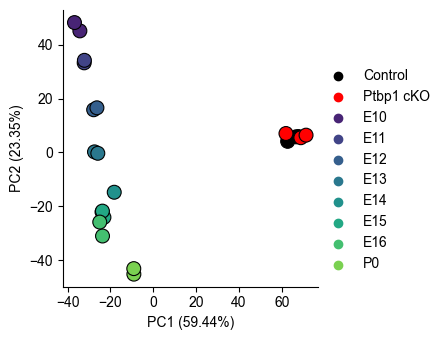

In [ ]:
g = sns.relplot(
    data = pca_df,
    x = "PC1",
    y = "PC2",
    hue = "group",
    hue_order = ["Control", "Ptbp1 cKO"] + ["E10", "E11", "E12", "E13", "E14", "E15", "E16", "P0"],
    s = 100,
    edgecolor = "black",
    height = 3.5,
    aspect = 1,
    palette = color_palette_dict
)
g.set_xlabels(f"PC1 ({PC1_contribution}%)")
g.set_ylabels(f"PC2 ({PC2_contribution}%)")
g._legend.set_title("")
plt.savefig("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/figure/PCA_TPM_vs_neuron_ENCODE.png", bbox_inches = "tight", dpi = 1000)

# Correlation of TPM

In [ ]:
DEG_path_dict = {
    "astrocyte": "/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/Shiba/results/expression/DEG.txt",
    "neuron": "/rhome/naotok/bigdata/NeuronalMaturationSplicing/splicing/ENCODE_Mouse_Forebrain/Shiba/results/expression/DEG.txt"
}

In [11]:
info_df = pd.read_csv("/rhome/naotok/bigdata/genome_annotation/Mouse/Mus_musculus.GRCm38.102.exon.info.tsv", sep = "\t", usecols = ["gene_id", "gene_name", "chr"])
info_df = info_df.drop_duplicates()

In [12]:
DEG_set = set()
for path in DEG_path_dict:
    DEG_df = pd.read_csv(DEG_path_dict[path], sep = "\t")
    DEG_df = DEG_df.rename(columns = {"gene_name": "gene_id"})
    DEG_df = pd.merge(DEG_df, info_df, on = "gene_id", how = "left")
    DEG_df = DEG_df[~((DEG_df["chr"] == "chrX") | (DEG_df["chr"] == "chrY"))]
    DEG_tmp = set(DEG_df[(DEG_df["padj"] < 0.05) & (DEG_df["log2FoldChange"].abs() > 1)]["gene_id"])
    DEG_set = DEG_set | DEG_tmp if len(DEG_set) != 0 else DEG_tmp

In [13]:
len(DEG_set)

10045

In [14]:
tpm_matrix_merge_melt_df = tpm_matrix_merge_df.reset_index().melt(id_vars = "gene_name", var_name = "sample", value_name = "TPM")
tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df[tpm_matrix_merge_melt_df["gene_name"].isin(DEG_set)]
tpm_matrix_merge_melt_df["group"] = tpm_matrix_merge_melt_df["sample"].map(lambda x: x.split("_")[0])
tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df.groupby(["gene_name", "group"], as_index = False).mean()
tpm_matrix_mean_df = tpm_matrix_merge_melt_df.pivot(index = "gene_name", columns = "group", values = "TPM")
tpm_matrix_mean_df = tpm_matrix_mean_df.rename(columns = {"WT": "Control", "KO": "Ptbp1 cKO"})
tpm_matrix_mean_df = tpm_matrix_mean_df[["Control", "Ptbp1 cKO", "E10", "P0"]]
tpm_matrix_mean_df = tpm_matrix_mean_df[tpm_matrix_mean_df.apply(lambda x: x > 10, axis = 1).any(axis = 1)]
tpm_matrix_mean_df = np.log2(tpm_matrix_mean_df+1)
tpm_matrix_mean_df

/scratch/naotok/13419516/ipykernel_2417904/316970571.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tpm_matrix_merge_melt_df = tpm_matrix_merge_melt_df.groupby(["gene_name", "group"], as_index = False).mean()


group,Control,Ptbp1 cKO,E10,P0
gene_name,,,,
ENSMUSG00000000028,3.817282,3.537296,6.585413,2.628774
ENSMUSG00000000031,0.616671,0.102098,6.871351,3.944858
ENSMUSG00000000058,6.642461,6.731636,3.040016,4.830610
ENSMUSG00000000078,5.012569,5.670161,5.323190,6.549361
ENSMUSG00000000120,1.246915,1.594549,4.731998,3.393004
...,...,...,...,...
ENSMUSG00000118100,3.101538,2.341986,3.650190,2.112700
ENSMUSG00000118134,0.973305,1.350497,4.188243,2.125982
ENSMUSG00000118164,0.559084,1.061200,2.502076,4.137094


In [15]:
tpm_matrix_mean_df.corr(method = "spearman")

group,Control,Ptbp1 cKO,E10,P0
group,,,,
Control,1.000000,0.984134,0.300100,0.465827
Ptbp1 cKO,0.984134,1.000000,0.294612,0.432981
E10,0.300100,0.294612,1.000000,0.272321
P0,0.465827,0.432981,0.272321,1.000000


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


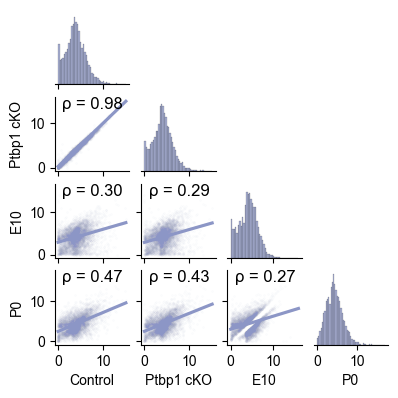

In [ ]:
g = sns.pairplot(
    data = tpm_matrix_mean_df,
    kind = "reg",
    corner = True,
    plot_kws = {
        "scatter_kws": {"alpha": 0.1, "s": 0.05, "color": "#8c96c6"},
        "line_kws": {"color": "#8c96c6"}
    },
    diag_kws = {"color": "#8c96c6"},
    height = 1
)
# Calculate and add Spearman's correlation coefficients in the same plot space
for i in range(len(g.axes)):
    for j in range(i):
        ax = g.axes[i, j]
        x = tpm_matrix_mean_df.iloc[:, j]
        y = tpm_matrix_mean_df.iloc[:, i]
        corr, _ = stats.spearmanr(x, y)
        ax.annotate(f"ρ = {corr:.2f}", 
                    xy=(0.1, 0.9), xycoords='axes fraction', 
                    ha='left', va='center', fontsize=12)
plt.savefig("/rhome/naotok/bigdata/Ptbp1_astrocyte/Jul24/figure/pairplot_TPM_vs_neuron_ENCODE.png", bbox_inches = "tight", dpi = 800)